# NYPD 911 Calls

In this project, we look at NYPD's database of $911$ calls during the period 2018-01-01 to 2022-09-30 from https://data.gov/. We collect this data from two sources, the **NYPD Calls for Service (Historic)** and **NYPD Calls for Service (Year to Date) datasets**. These datasets house approximately $26$ million and $5.94$ million incidents respectively as of 2022-10-20.

These datasets feature a huge number of rows, so we cannot possibly load the entire dataset at once. We'll load them in chunks of $1$ million rows at a time.

In [1]:
# import useful libraries
import pandas as pd
from datetime import datetime
from dateutil.rrule import rrule, DAILY
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# load first 1 million rows of historic call data
calls = pd.read_csv("NYPD_Calls_for_Service__Historic_.csv", nrows = 10**6)

print(calls.shape)
calls.head()

(1000000, 19)


,OBJECTID,CAD_EVNT_ID,CREATE_DATE,INCIDENT_DATE,INCIDENT_TIME,NYPD_PCT_CD,BORO_NM,PATRL_BORO_NM,GEO_CD_X,GEO_CD_Y,RADIO_CODE,TYP_DESC,CIP_JOBS,ADD_TS,DISP_TS,ARRIVD_TS,CLOSNG_TS,Latitude,Longitude
0,1168025.0,66231134,02/17/2020,02/17/2020,1899-12-30T00:00:00.000,75.0,BROOKLYN,PATROL BORO BKLYN NORTH,1019935,186241,75D,VISIBILITY PATROL: DIRECTED,Non CIP,02/17/2020 03:29:46 AM,02/17/2020 03:29:46 AM,02/17/2020 03:29:47 AM,02/17/2020 08:06:06 AM,40.677802,-73.871348
1,1168033.0,66245138,02/17/2020,02/17/2020,1899-12-30T00:00:00.000,75.0,BROOKLYN,PATROL BORO BKLYN NORTH,1020003,184164,75D,VISIBILITY PATROL: DIRECTED,Non CIP,02/17/2020 03:56:56 PM,02/17/2020 03:56:56 PM,02/17/2020 03:56:57 PM,02/17/2020 04:28:04 PM,40.672100,-73.871114
2,1168031.0,66231843,02/17/2020,02/17/2020,1899-12-30T00:00:00.000,75.0,BROOKLYN,PATROL BORO BKLYN NORTH,1020080,184471,75D,VISIBILITY PATROL: DIRECTED,Non CIP,02/17/2020 04:32:35 AM,02/17/2020 04:32:35 AM,02/17/2020 04:32:36 AM,02/17/2020 07:51:59 AM,40.672943,-73.870835
3,1168032.0,66245081,02/17/2020,02/17/2020,1899-12-30T00:00:00.000,75.0,BROOKLYN,PATROL BORO BKLYN NORTH,1020080,184471,75D,VISIBILITY PATROL: DIRECTED,Non CIP,02/17/2020 03:55:38 PM,02/17/2020 03:55:38 PM,02/17/2020 03:55:39 PM,02/17/2020 04:56:56 PM,40.672943,-73.870835
4,1168034.0,66228337,02/17/2020,02/17/2020,1899-12-30T00:00:00.000,75.0,BROOKLYN,PATROL BORO BKLYN NORTH,1020214,183053,75D,VISIBILITY PATROL: DIRECTED,Non CIP,02/17/2020 12:24:36 AM,02/17/2020 12:24:36 AM,02/17/2020 12:24:37 AM,02/17/2020 12:30:16 AM,40.669050,-73.870359


There's a lot of information provided for each individual call. We're interested in seeing whether we can build a model capable of **forecasting future 911 calls** reasonably, to **help plan demand for 911 call dispatchers in future dates**. In order to do so, let's collect the number of calls received by dispatchers each day in our dataset.

In [3]:
# create dictionary with unique dates as keys
# and the # of calls that day as its corresponding value
call_counts = dict(calls.groupby('INCIDENT_DATE').size())
call_counts

{'01/01/2021': 3,
 '01/04/2020': 18,
 '01/05/2020': 1042,
 '01/06/2020': 3006,
 '01/07/2020': 2677,
 '01/08/2020': 2611,
 '01/09/2020': 4170,
 '01/10/2020': 4694,
 '01/11/2020': 3328,
 '01/12/2020': 1172,
 '01/13/2020': 3329,
 '01/14/2020': 3640,
 '01/15/2020': 3398,
 '01/16/2020': 3990,
 '01/17/2020': 6765,
 '01/18/2020': 2664,
 '01/19/2020': 1499,
 '01/20/2020': 3395,
 '01/21/2020': 3639,
 '01/22/2020': 4125,
 '01/23/2020': 4109,
 '01/24/2020': 6672,
 '01/25/2020': 2046,
 '01/26/2020': 1233,
 '01/27/2020': 1511,
 '01/28/2020': 3687,
 '01/29/2020': 5112,
 '01/30/2020': 4233,
 '01/31/2020': 5222,
 '02/01/2020': 310,
 '02/02/2020': 2292,
 '02/03/2020': 2516,
 '02/04/2020': 6795,
 '02/05/2020': 5830,
 '02/06/2020': 6375,
 '02/07/2020': 4198,
 '02/08/2020': 603,
 '02/09/2020': 2758,
 '02/10/2020': 3027,
 '02/11/2020': 4230,
 '02/12/2020': 4243,
 '02/13/2020': 4020,
 '02/14/2020': 4730,
 '02/15/2020': 951,
 '02/16/2020': 1899,
 '02/17/2020': 2650,
 '02/18/2020': 3882,
 '02/19/2020': 4159,


In [4]:
# loop over entire dataset of historic calls, updating our dictionary
# with new counts of calls and new dates
for i in range(1, 27, 1):
    calls = pd.read_csv("NYPD_Calls_for_Service__Historic_.csv", nrows = 10**6, skiprows = range(1, i * 10**6, 1))
    calls_by_day = dict(calls.groupby('INCIDENT_DATE').size())
    for date in calls_by_day.keys():
        if date in call_counts:
            call_counts[date] = call_counts[date] + calls_by_day[date]
        else:
            call_counts[date] = calls_by_day[date]

# loop over our year-to-date dataset and update our dictionary
# with these new counts as well
calls = pd.read_csv("NYPD_Calls_for_Service__Year_to_Date_.csv", nrows = 10**6)
calls_by_day = dict(calls.groupby('INCIDENT_DATE').size())
for date in calls_by_day.keys():
    if date in call_counts:
        call_counts[date] = call_counts[date] + calls_by_day[date]
    else:
        call_counts[date] = calls_by_day[date]
for i in range(1, 6, 1):
    calls = pd.read_csv("NYPD_Calls_for_Service__Year_to_Date_.csv", nrows = 10**6, skiprows = range(1, i * 10**6, 1))
    calls_by_day = dict(calls.groupby('INCIDENT_DATE').size())
    for date in calls_by_day.keys():
        if date in call_counts:
            call_counts[date] = call_counts[date] + calls_by_day[date]
        else:
            call_counts[date] = calls_by_day[date]

Now that we have all our dates and the number of $911$ calls received each of these days, let's convert this into a dataframe and do some **feature engineering** to supplement our data with the **weekday**, **day** and **month** of each timestep.

In [5]:
# convert dictionary of counts into a dataframe
calls = pd.DataFrame.from_dict(call_counts, orient = 'index', columns = ['#calls'])
calls.reset_index(inplace = True)
calls.columns = ['dates', '#calls']

# convert dates into datetime type and sort rows by date
calls['dates'] = pd.to_datetime(calls['dates'])
calls.sort_values(by = ['dates'], inplace = True)
calls.reset_index(inplace = True, drop = True)

# create new variables for the weekday, day and month of each date
calls['weekday'] = calls['dates'].apply(lambda x: x.weekday())
calls['day'] = calls['dates'].dt.day
calls['month'] = calls['dates'].dt.month

print(calls.shape)
calls

(1734, 5)


,dates,#calls,weekday,day,month
0,2018-01-01,16007,0,1,1
1,2018-01-02,16324,1,2,1
2,2018-01-03,16980,2,3,1
3,2018-01-04,14831,3,4,1
4,2018-01-05,17251,4,5,1
...,...,...,...,...,...
1729,2022-09-26,19630,0,26,9
1730,2022-09-27,20609,1,27,9
1731,2022-09-28,21410,2,28,9
1732,2022-09-29,20929,3,29,9


Text(0.5, 1.0, '# of 911 Calls from 2018-01-01 to 2022-09-30')

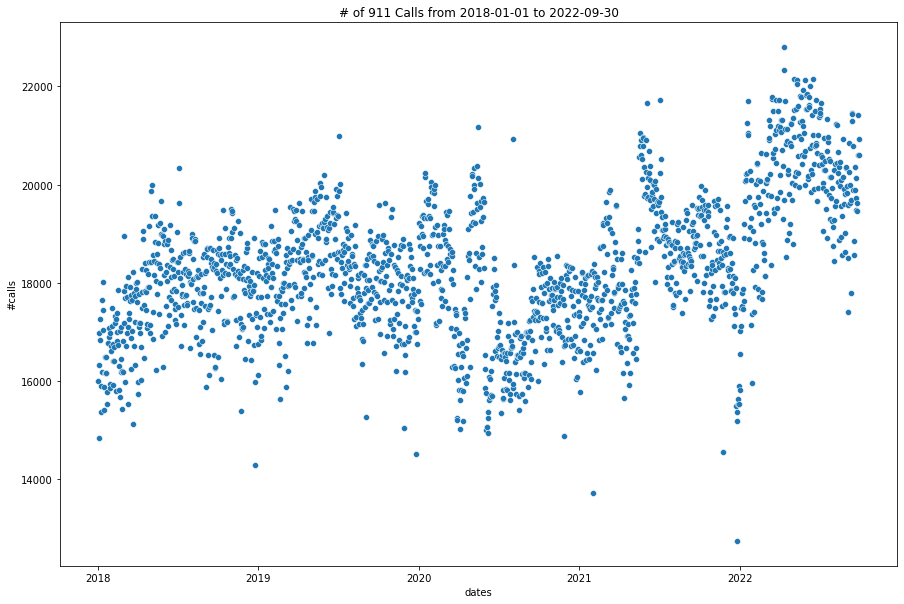

In [6]:
# plot scatter plot of 911 calls
plt.figure(figsize = (15, 10))
sns.scatterplot(data = calls, x = 'dates', y = '#calls')
plt.title("# of 911 Calls from 2018-01-01 to 2022-09-30")

This data looks pretty good so far! Let's check whether our dates are all **consecutive**, or if we're missing data on any specific dates.

In [7]:
# get ordinal numbers for each date
date_ints = set(calls['dates'].apply(lambda x: x.toordinal()))

# check whether our dates in the dataframe are consecutive
if len(date_ints) == 1:
    print("unique")
elif max(date_ints) - min(date_ints) == len(date_ints) - 1:
    print("consecutive")
else:
    print("not consecutive")

consecutive


Awesome! Looks like we don't have any missing dates in our data.

In [8]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1734 entries, 0 to 1733
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   dates    1734 non-null   datetime64[ns]
 1   #calls   1734 non-null   int64         
 2   weekday  1734 non-null   int64         
 3   day      1734 non-null   int64         
 4   month    1734 non-null   int64         
dtypes: datetime64[ns](1), int64(4)
memory usage: 67.9 KB


Text(0.5, 1.0, '# of 911 Calls from 2018-01-01 to 2022-09-30')

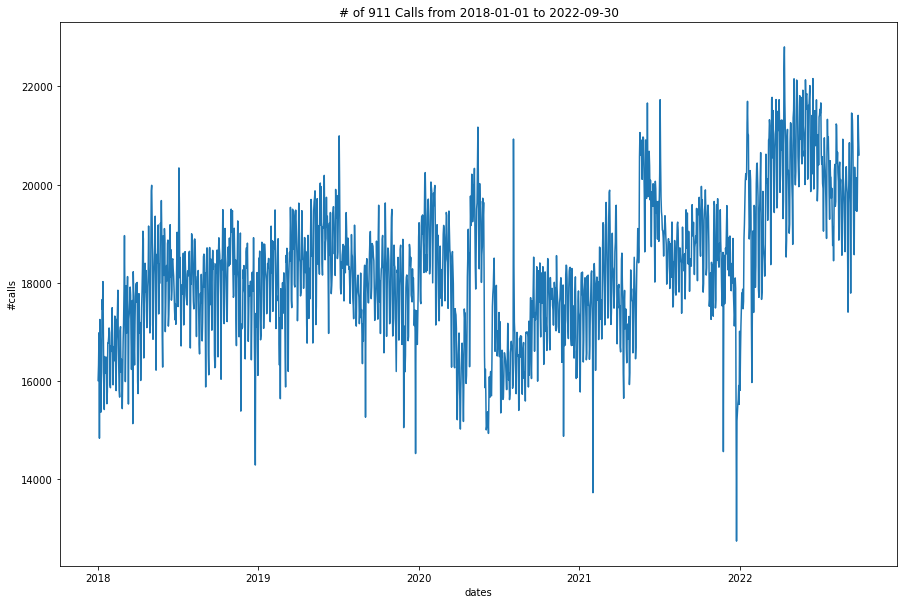

In [9]:
plt.figure(figsize = (15, 10))
sns.lineplot(data = calls, x = 'dates', y = '#calls')
plt.title("# of 911 Calls from 2018-01-01 to 2022-09-30")

Now that we have our data in a more useful format, let's save this dataframe under a new **csv file** so we can more easily access it without having to process it again.

In [10]:
calls.to_csv('NYPD_Calls_by_date.csv', index = False)